In [1041]:
a1 = open('a1.txt')
file = a1.readlines()


In [1042]:
import re
import numpy as np
import matplotlib.pyplot as plt

p = re.compile('\d+')

data = []

for line in file:
    x, y = p.findall(line)
    data.append([int(x),int(y)])
    
data = np.array(data)


Text(0, 0.5, 'frequency')

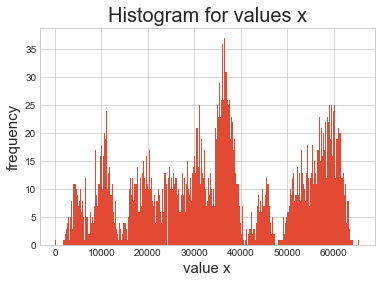

In [1256]:
x_hist = plt.hist(data[:,0], bins=300)
plt.title('Histogram for values x', size=20)
plt.xlabel('value x',size=15)
plt.ylabel('frequency', size=15)

Text(0, 0.5, 'frequency')

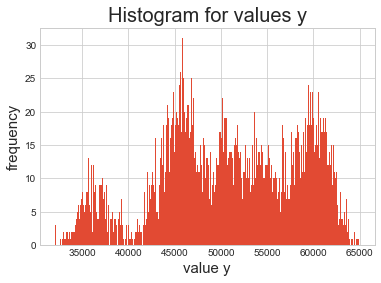

In [1257]:
y_hist = plt.hist(data[:,1], bins=300)
plt.title('Histogram for values y', size=20)
plt.xlabel('value y',size=15)
plt.ylabel('frequency', size=15)

In [1223]:
import copy

class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=800, centroids=None):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        self.dist_l = []
        self.centroids = centroids
        if self.centroids is not None:
            self.k = len(centroids)
        
    def fit(self, data):
        self.dist_l = []
        
        self.data = data

        if self.centroids is None :
            self.centroids = {k:v for k,v in enumerate(np.array(random.sample(list(data),self.k)))}

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset - self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid - original_centroid) / original_centroid * 100.0) > self.tol:
#                     print(np.sum((current_centroid - original_centroid) / original_centroid * 100.0))
                    optimized = False
    
            self.dist_l.append(self.calcul_dist())
        
            if optimized:
                break

    def predict(self, data):
        distances = [np.linalg.norm(data - self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification
    
    def calcul_dist(self):
        tot_dist = 0
        for key,val in self.classifications.items():
            for p in val:
                dist = np.linalg.norm(self.centroids[key]-p)
                tot_dist += dist
        return tot_dist
    
    def get_farthest_data(self):
        max_dist = 0
        max_dist_p = ()
        for p in self.data:
            sub_min_dist = 10e10
            for c in self.centroids.values():
                if sub_min_dist > np.linalg.norm(c - p):
                    sub_min_dist = np.linalg.norm(c - p)
            if max_dist < sub_min_dist:
                max_dist = sub_min_dist
                max_dist_p = p
        return max_dist_p
                
    def add_centroid(self, p):
        self.centroids[self.k] = p
        self.k += 1
        
    def draw_plot(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 8))
        for k in self.classifications.keys():
            x_l = np.array(self.classifications[k])[:,0]
            y_l = np.array(self.classifications[k])[:,1]
            plt.scatter(x_l,y_l)
            plt.scatter(np.array(self.centroids[k])[0], np.array(self.centroids[k])[1], color='black')

        

# Random initial point

In [1225]:
random_model = K_Means(k = 20)

random_model.fit(data)

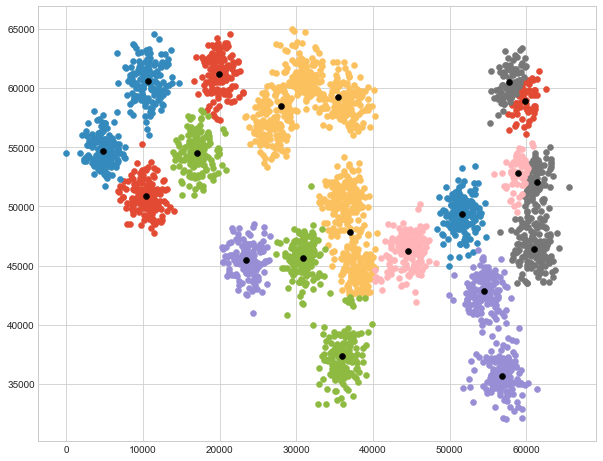

In [1226]:
random_model.draw_plot()

# k-means ++

In [1215]:
def get_init_centroids(k, data):
    k = 20
    init_centroids = {0:random.choice(data)}

    while len(init_centroids) < k:
        max_dist_p = 0
        max_dist = 0
        for p in data:
            min_dist_c_idx = 0
            min_dist_c = 10e10
            for c_idx,c  in init_centroids.items():
                if min_dist_c > np.linalg.norm(c - p):
                    min_dist_c_idx = c_idx
                    min_dist_c = np.linalg.norm(c - p)
            if max_dist < min_dist_c:
                max_dist = min_dist_c
                max_dist_p = p

        init_centroids[len(init_centroids)] = max_dist_p
    return init_centroids

In [1216]:
init_centroids = get_init_centroids(k, data)

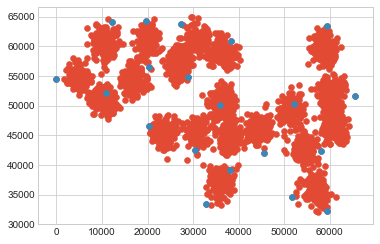

In [1217]:
plt.scatter(data[:,0],data[:,1])
plt.scatter([x for x,y in init_centroids.values()],[y for x,y in init_centroids.values()])

In [1218]:
k_pp_model = K_Means(centroids=init_centroids)

k_pp_model.fit(data)

/Users/hyunwoo/anaconda3/envs/optlab/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


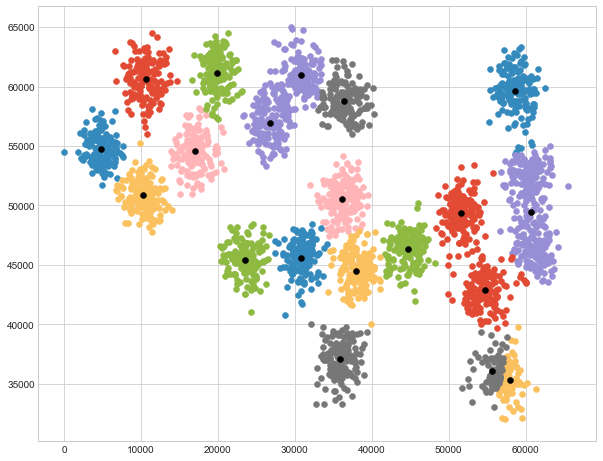

In [1219]:
k_pp_model.draw_plot()

# Automatically choose number of K

하나씩 늘리되, 일정 비율이상 좋아지지 않으면 그만둔다.
하나씩 늘리는 방법은 클러스터와 가장 먼 데이터에 새로운 initial point을 두는 것이다.

In [1228]:
def check_reduced_ratio(model, p, threshold=0.2):
    new_model = copy.deepcopy(model)
    new_model.add_centroid(p)

    new_model.fit(model.data)

    if 1-(new_model.dist_l[-1]/model.dist_l[-1]) > threshold:
        return new_model
    else:
        return False

In [1229]:
def auto_k_means(X, threshold=0.1, tolerance=2):
    model = K_Means()
    model.fit(X)
    strike = 0
    while True:
#         prev_tot_dist = model.dist_l[-1]

        new_init_p = model.get_farthest_data()
        
        new_model = check_reduced_ratio(model, new_init_p, threshold=threshold)
        
        if new_model:
            model = new_model
        else:
            strike += 1
            
        if strike >= tolerance:
            break
            
    return model

In [1230]:
result = auto_k_means(data, threshold=0.03, tolerance=3)

/Users/hyunwoo/anaconda3/envs/optlab/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


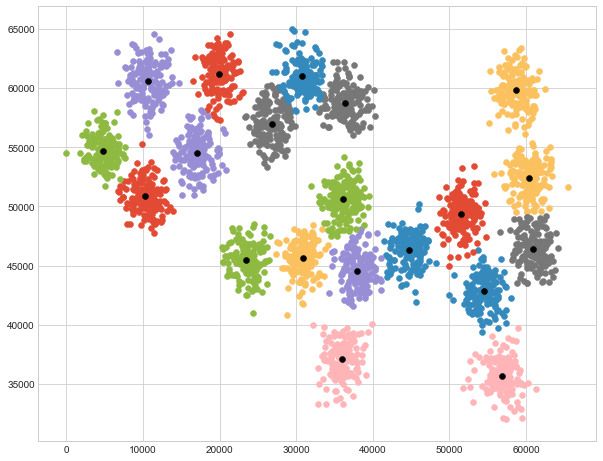

In [1231]:
result.draw_plot()

In [1234]:
result.dist_l[-1]

5377315.524724559

# Elbow method with Scikit learn k-means

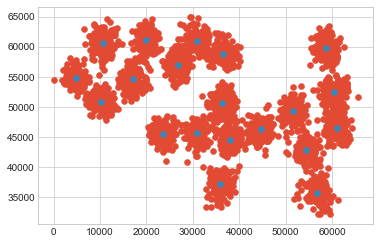

In [1236]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=20, random_state=0).fit(data)
sk_centroids = kmeans.cluster_centers_

plt.scatter([x for x,y in data],[y for x,y in data])
plt.scatter([x for x,y in sk_centroids], [y for x,y in sk_centroids])

In [1237]:
elbow_l = []
elbow_l2 = []

for i in range(2,50):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(data)
    elbow_l2.append(kmeans.inertia_)
     
    classified = {i:[] for i in range(kmeans.n_clusters)}
    
    for idx,val in enumerate(kmeans.labels_):
        classified[val].append(idx)
    
    tot_dist = 0
    for key,val in classified.items():
        for p in val:
            dist = np.linalg.norm(kmeans.cluster_centers_[key] - data[p])
            tot_dist += dist
    elbow_l.append(tot_dist)

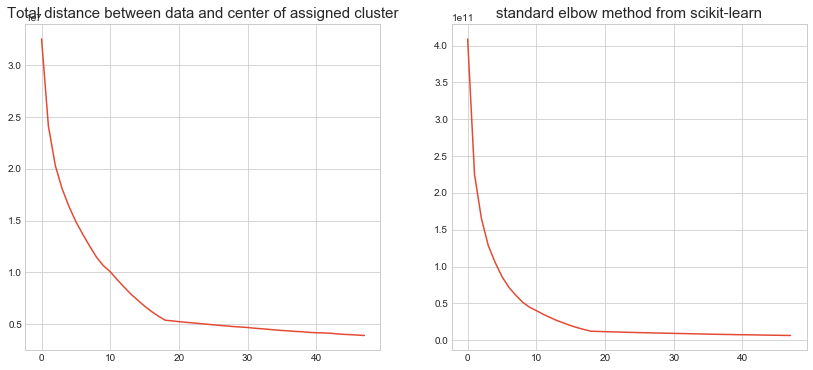

In [1238]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((14,6))

axs[0].set_title('Total distance between data and center of assigned cluster', size=15)
axs[0].plot(elbow_l)

axs[1].set_title('standard elbow method from scikit-learn', size=15)
axs[1].plot(elbow_l2)

In [1056]:
# 10~15 will be selected by elbow method

# Test with  iris data


In [1239]:
from sklearn import datasets
import itertools

iris = datasets.load_iris()
comb_l = list(itertools.combinations(list(range(len(iris['data'][0]))), 2))

X = iris.data*100
X = X.astype(np.int64)


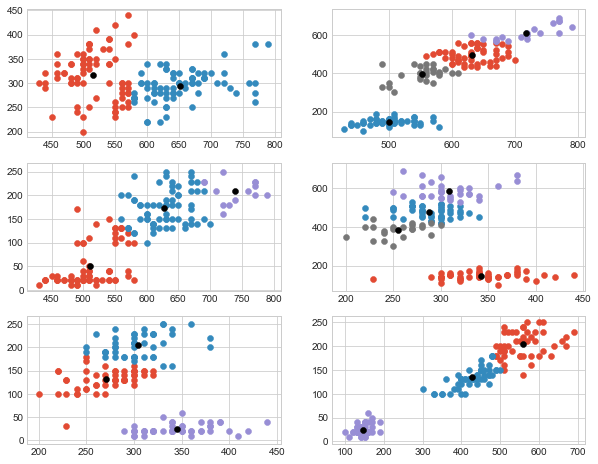

In [1240]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches((10,8))

fig_num = 0
for comb in comb_l:
    slctd_X = X[:,comb]
    
    selctd_result = auto_k_means(slctd_X, threshold=0.15, tolerance=2)
    
    for k in selctd_result.classifications.keys():
        x_l = np.array(selctd_result.classifications[k])[:,0]
        y_l = np.array(selctd_result.classifications[k])[:,1]
        axs[fig_num//2, fig_num%2].scatter(x_l,y_l)
        axs[fig_num//2, fig_num%2].scatter(np.array(selctd_result.centroids[k])[0], np.array(selctd_result.centroids[k])[1], color='black')
    
    fig_num += 1